In [194]:
# !pip install nameparser
# !pip install lightgbm
# # !pip install catboost

# Tree-Based Prediction Models on Titanic Dataset

## Summary
Just wanted to perform a quick analysis using Tree-Based Models to make a prediction on the Titanic dataset.  Many have done and contributed their exploratory data analyses in Kaggle.  Based on these analyses, the focus here is to perform some quick data transformation and feature engineering, follow by model training and prediction.  Finally, generating the submission csv for assessment in Kaggle.

I aim for this notebook to be short and not dwell in too much details on why certain parameters or models are selected.  Purpose is for tree-based models to perform well in making predictions on unseen data.

---
## Importing Libraries

In [158]:
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# %matplotlib inline

import re

import warnings
warnings.filterwarnings('ignore')

## Changing the default settings
pd.options.display.max_columns = 50
# plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})

DATA_FOLDER = '../data/'
OUTPUT_FOLDER = '../output/'

import os
for dirname, _, filenames in os.walk(DATA_FOLDER):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/.DS_Store
../data/test.csv
../data/train.csv
../data/gender_submission.csv


---
## Loading the Dataset

Some quick information

In [159]:

train = pd.read_csv(DATA_FOLDER + 'train.csv', index_col='PassengerId')
test = pd.read_csv(DATA_FOLDER + 'test.csv', index_col='PassengerId')
submission = pd.read_csv(DATA_FOLDER + 'gender_submission.csv')

target = [col for col in train.columns if col not in test.columns]
features = [col for col in train.columns if col in test.columns]

num_features = train._get_numeric_data().columns.tolist()
cat_features = [col for col in train.columns if col not in num_features]

print('Target: {}'.format(target))
print('List of features: {}'.format(features))
print('List of numeric features: {}'.format(num_features))
print('List of categorical features: {}'.format(cat_features))

Target: ['Survived']
List of features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
List of numeric features: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
List of categorical features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


Pclass should be classified at categorical features instead.

In [160]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


---
## Helper Functions

1. **combineTrainTest** - For data transformation and feature engineering with needs to be applied to both Train and Test set consistently.
2. **splitTrainTest** - For splitting the combined dataset back to train and test after data transformation and feature engineering.
3. **plot_importances** - For showing the feature importances as determined by the model.

In [161]:
def combineTrainTest(train, test, features):
    train = train[features]
    test = test[features]
    out = pd.concat([train, test])
    return out

def splitTrainTest(traintest, train, test, target):
    train = traintest.loc[train.index].join(train[target])
    test = traintest.loc[test.index]
    return train, test

def plot_importances(model, columns, top=20):
    importances = pd.Series(data=model.feature_importances_, index=columns).sort_values()

    plt.figure(figsize=(10,6))
    importances[-top:].sort_values().plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()
     

---
## Data Analysis and Feature Engineering

Combining the train and test set together so that data transformation will be consistent and applied to both datasets.

In [162]:
traintest = combineTrainTest(train, test, features)

Check columns with null values

In [163]:
traintest.isnull().any()

Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare         True
Cabin        True
Embarked     True
dtype: bool

### Embarked

There is 2 records with no Embarked information.  Will fill the missing values with the mode of all Embarked field.

In [164]:
traintest[traintest.Embarked.isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [165]:
modeEmbarked = traintest.Embarked.mode(dropna=True)[0]
traintest.Embarked.fillna(modeEmbarked, inplace=True)

### Fare

There is only 1 record with missing Fare.  To update with median of all Fares with same Embarked, SibSp, Parch, Pclass

In [166]:
traintest[traintest.Fare.isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [167]:
medianFare = traintest[(traintest.Pclass == 3) & 
          (traintest.Embarked == 'S') & 
          (traintest.SibSp == 0) & 
          (traintest.Parch == 0)].Fare.median()

print('Median Fare to fill NA fare: {}'.format(medianFare))

Median Fare to fill NA fare: 7.8958


Neatly updated with **Groupby - Transform**

In [168]:
traintest['Fare'] = traintest.groupby(['Pclass', 'Embarked', 'SibSp', 'Parch'])['Fare'].transform(lambda x: x.fillna(x.median()))

### Cabin

There are a couple of information that can be engineered out from the Cabin data.  New features engineered:
- **Deck**: first character of each cabin
- **Rooms**: number of rooms book by each individual.  Possibly connecting rooms if more than 1.
- **RoomNum**: Room number.  Expect rooms to be numbered in sequence on each deck.  Eg: Small number at the front and bigger number at the back.
- **NoCabin**: Whether the passenger was assigned a cabin.  Passenger with no cabin could be working on the ship.  On the other hand, if they are working on the ship why would they have tickets and fares?

**<span style='color:red'>EXCLUDED</span>**<br>
All except NoCabin were excluded because these features did not appear to be important for survival predictions.  Sinking of the ships took time.  Unlikely the passengers would remain in the rooms and allocated deck when fighting for survival.  Cabin data not likely to be useful to determine whether passenger belonged to Upper or Lower class.

In [169]:
# traintest['Deck'] = traintest['Cabin'].str[0]

# traintest['RoomNum'] = traintest['Cabin'].apply(lambda x: x.split()[-1][1:] if x is not np.nan else -1)
# traintest.loc[traintest['RoomNum'] == '', 'RoomNum'] = -0
# traintest.RoomNum = traintest.RoomNum.astype(int)

# traintest['Rooms'] = traintest['Cabin'].apply(lambda x: len(x.split()) if x is not np.nan else -1)

traintest['NoCabin'] = traintest['Cabin'].isnull()

### Name

Titles of each individuals can be engineering out from the names.  Using **nameparser** library to help in the extraction to create the new **Title** feature.

In addition, the last name can be extracted and be used as an potential indicator whether the individual come from a large family.

**<span style='color:red'>EXCLUDED</span>**<br>
Last Name Size did not appear to be important for survival prediction.

In [170]:
from nameparser import HumanName
traintest['Title'] = traintest.Name.apply(lambda x: HumanName(x)['title'])
traintest['Title'] = traintest['Title'].str.replace('[^\w\s]','')
traintest['Title'] = traintest['Title'].str.replace('the Countess of','Countess')


In [171]:
traintest['LastName'] = traintest.Name.apply(lambda x: HumanName(x)['last'])
# lastname = traintest.groupby('LastName').size().sort_values(ascending=False)

# lastname_map = {
#     1: "Single",
#     2: "Small",
#     3: "Small",
#     4: "Normal",
#     5: "Normal",
#     6: "Normal",
#     7: "Big",
#     8: "Big",
#     9: "Big",
#     10: "Huge",
#     11: "Huge",
# }

# traintest['LastNameSize'] = traintest['LastName'].replace(lastname.replace(lastname_map).to_dict())

### Ticket

**<span style='color:red'>EXCLUDED</span>**<br>
Ticket information will be dropped.  None of the features engineered from ticket appears to be useful

In [172]:
# def processTicket(ticket):
#     if len(ticket.split()) > 1:
#         if len(''.join(ticket.split()[1:])) > 2:
#             tickettype, ticketbatch = re.sub(r'[^\w\s]','',ticket.split()[0]), ''.join(ticket.split()[1:])[:-2]
#         else:
#             tickettype, ticketbatch = re.sub(r'[^\w\s]','',ticket.split()[0]), ''.join(ticket.split()[1:])
#     else:
#         tickettype, ticketbatch = 'Number', ticket[:-2]
#     return tickettype, ticketbatch 

In [173]:
# traintest[['TicketType', 'TicketBatch']] = traintest.Ticket.apply(lambda x: processTicket(x)).apply(pd.Series)

### Age

Filling up missing Age with median of passengers with the same **Title** groupings

In [174]:
traintest['Age'] = traintest.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

### Others

1. Binning the less popular titles into Others
2. Create additional feature to represent Family size by adding SibSp, Parch and 1.


In [175]:
## Select the top 4 titles only
topTitle = traintest.groupby('Title').size().sort_values(ascending=False)[0:4].index.tolist()
traintest['Title'] = traintest['Title'].apply(lambda x: x if x in topTitle else 'Other')

traintest['FamilySize'] = traintest.SibSp + traintest.Parch + 1

### Others

1. **AgeGroup**: Binning of Age
2. **FareGroup**: Binning of Fare
3. **Fare_Calculate**: Average Fare by Family Size
4. **FareCalcGroup**: Binning of Fare_Calculate
5. **IsAlone**: Whether the passenger is alone

In [176]:
traintest['AgeGroup'] = pd.cut(traintest['Age'].astype(int), 5, labels=['Child','Young','Adult','Old','Aged'])
traintest['FareGroup'] = pd.qcut(traintest['Fare'], 4, labels=['Low','Average','High','Overpriced'])
traintest['Fare_Calculate'] = traintest['Fare'] / traintest['FamilySize']
traintest['FareCalcGroup'] = pd.qcut(traintest['Fare_Calculate'], 4, labels=['Low','Average','High','Overpriced'])
traintest['IsAlone'] = traintest['FamilySize'] == 1

### One-hot Encoding for Categorial Variables
- Title
- Embarked
- Sex
- Age Group
- Fare Group
- Fare Calculate Group

**<span style='color:red'>EXCLUDED</span>**<br>
- Deck
- Last Name Size
- Ticket Type
- Ticket Batch

In [177]:
traintest = traintest.join(pd.get_dummies(traintest.Title, drop_first=True, prefix='Title')).drop('Title', axis=1)
traintest = traintest.join(pd.get_dummies(traintest.Embarked, drop_first=True, prefix='Embarked')).drop('Embarked', axis=1)
traintest = traintest.join(pd.get_dummies(traintest.Sex, drop_first=True, prefix='Sex')).drop('Sex', axis=1)
traintest = traintest.join(pd.get_dummies(traintest.AgeGroup, drop_first=True, prefix='AgeGroup')).drop('AgeGroup', axis=1)
traintest = traintest.join(pd.get_dummies(traintest.FareGroup, drop_first=True, prefix='FareGroup')).drop('FareGroup', axis=1)
traintest = traintest.join(pd.get_dummies(traintest.FareCalcGroup, drop_first=True, prefix='FareCalcGroup')).drop('FareCalcGroup', axis=1)

## NOT USEFUL
# traintest = traintest.join(pd.get_dummies(traintest.Deck, prefix='Deck')).drop('Deck', axis=1)
# traintest = traintest.join(pd.get_dummies(traintest.LastNameSize, drop_first=True, prefix='LastNameSize')).drop('LastNameSize', axis=1)
# traintest = traintest.join(pd.get_dummies(traintest.TicketType, drop_first=True, prefix='TicketType')).drop('TicketType', axis=1)
# traintest = traintest.join(pd.get_dummies(traintest.TicketBatch, drop_first=True, prefix='TicketBatch')).drop('TicketBatch', axis=1)

Dropping columns deemed not useful now for tree-based model for now
- Name
- Ticket
- Cabin
- Last Name

In [178]:
traintest.drop(['Name', 'Ticket', 'Cabin', 'LastName'], inplace=True, axis=1)

In [179]:
traintest.shape

(1309, 26)

In [180]:
print('Missing data in columns: {}'.format(traintest.isnull().any().any()))

Missing data in columns: False


In [181]:
Xy, X_test = splitTrainTest(traintest, train, test, target)

X = Xy.drop(target, axis=1)
y = Xy[target]

print(X.shape)
print(y.shape)
print(X_test.shape)

(891, 26)
(891, 1)
(418, 26)


In [182]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,NoCabin,FamilySize,Fare_Calculate,IsAlone,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Embarked_Q,Embarked_S,Sex_male,AgeGroup_Young,AgeGroup_Adult,AgeGroup_Old,AgeGroup_Aged,FareGroup_Average,FareGroup_High,FareGroup_Overpriced,FareCalcGroup_Average,FareCalcGroup_High,FareCalcGroup_Overpriced
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,22.0,1,0,7.2500,True,2,3.62500,False,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
2,1,38.0,1,0,71.2833,False,2,35.64165,False,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1
3,3,26.0,0,0,7.9250,True,1,7.92500,True,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0
4,1,35.0,1,0,53.1000,False,2,26.55000,False,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1
5,3,35.0,0,0,8.0500,True,1,8.05000,True,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0


## Tree-Based Model Training

Focus on the following models:
1. Adaptive Boosting (Adaboost)
2. Support Vector Machine (SVM)
3. CatBoost
4. LightGBM
5. Random Forest
6. Histogram-Based Gradient Boosting
6. Gradient Boosting Machine
7. XGBoost
8. Voting Classifier

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV

SEED = 3567

# gb = GradientBoostingClassifier(max_depth=6, subsample=0.9, max_features=0.3, n_estimators=180, random_state=SEED)
# rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=SEED)
# ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=SEED)
# dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=0.13, random_state=SEED)
# cat = CatBoostClassifier(n_estimators=100, subsample=0.8, max_depth=4, learning_rate=0.01)

Preparing parameters for hyperparameters tuning using GridSearchCV

In [184]:
models = [
    ('ada', AdaBoostClassifier()),
    ('svc', SVC(probability=True)),    
    ('cat', CatBoostClassifier(verbose=0)),
    ('lgbm', LGBMClassifier()),
    ('hgb', HistGradientBoostingClassifier()),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('xgb', XGBClassifier())
]

{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 8, 
 'n_estimators': 200, 'random_state': 3567, 'reg_alpha': 0.1, 'reg_lambda': 0.9, 'subsample': 0.8}

n_estimators = [500]
max_features = [0.8]
max_depth = [6, 8, 10]
learning_rate = [.01, .03, .05]
gamma = [0.01, 0.02, 0.03]
subsample = [0.8, 0.9, 1]

# n_estimators = list(np.arange(150,220,30))
# max_features = list(np.arange(0.5,1.0,0.2))
# max_depth = list(np.arange(7,12,2))
# colsample_bytree = list(np.arange(0.3,0.6,0.2))
# lambda_l2 = list(np.arange(0.6,1.0,0.3))
# alpha_l1 = list(np.arange(0.01,0.1,0.04))

grid_param = [
    [{ ## ada
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'random_state': [SEED]
    }],
    [{ ## svc
        'C': [1,2,3,4,5],
        'gamma': gamma,
        'decision_function_shape': ['ovo', 'ovr'],
        'probability': [True],
        'random_state': [SEED] 
    }],    
    [{ ## cat
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'subsample': subsample,
        'random_state': [SEED]  
    }],
    [{ ## lgbm
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
#         'reg_alpha': alpha_l1,
#         'reg_lambda': lambda_l2,
        'subsample': subsample,
        'colsample_bytree': max_features,
        'random_state': [SEED]  
    }],
    [{ ## hgb
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'random_state': [SEED]
    }],
    [{ ## rf
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'max_samples': subsample,
        'criterion': ['gini', 'entropy'],
        'oob_score': [True],
        'random_state': [SEED]
    }],
    [{ ## gb
        'n_estimators': n_estimators,
        'subsample': subsample,
        'max_features': max_features,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'random_state': [SEED]
    }],
    [{ ## xgb
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'gamma': gamma,
#         'reg_alpha': alpha_l1,
#         'reg_lambda': lambda_l2,
        'subsample': subsample,
        'colsample_bytree': max_features,
        'seed': [SEED]  
    }]
]

Cross Validation Splits

In [185]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
# cv_split = ShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8, random_state = SEED)
cv_split = RepeatedStratifiedKFold(n_splits=20, n_repeats=5, random_state=SEED)

Tuning all models to prepare for Voting Classifier.  This will take a long time to run.

In [186]:
start_total = time.perf_counter()

for model, param in zip (models, grid_param):

    print(model[1])
    print(param)
    
    start = time.perf_counter()        
    best_search = GridSearchCV(estimator=model[1], param_grid=param, cv=cv_split, scoring='roc_auc', verbose=0)
    best_search.fit(X, y)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('\n######')
    print('The best parameter for {} is {} with a runtime of {:.2f} minutes.'.format(model[1].__class__.__name__, 
                                                                                     best_param, run/60))
    model[1].set_params(**best_param) 

    print('######\n')

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
[{'n_estimators': [500], 'learning_rate': [0.01, 0.03, 0.05], 'random_state': [3567]}]
######
The best parameter for AdaBoostClassifier is {'learning_rate': 0.05, 'n_estimators': 500, 'random_state': 3567} with a runtime of 5.92 minutes.
######

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
[{'C': [1, 2, 3, 4, 5], 'gamma': [0.01, 0.02, 0.03], 'decision_function_shape': ['ovo', 'ovr'], 'probability': [True], 'random_state': [3567]}]
######
The best parameter for SVC is {'C': 5, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'probability': True, 'random_state': 3567} with a runtime of 7.07 minutes.
######

[{'learning_rate': [0.01, 0.03, 0.05], 'max_dept

## Training and Validation Results

Consolidating the results

In [187]:
from tqdm import tqdm_notebook as tqdm

results = []
for m in tqdm(models):
    result = {}
#     print('{} - {}'.format(m[0], type(m[1]).__name__))
    print('Processing {}...'.format(type(m[1]).__name__))

    m_cv = cross_validate(m[1], X, y, cv=cv_split, return_train_score=True)
    
    result['Model'] = type(m[1]).__name__
    result['TrainScore'] = m_cv['train_score'].mean()*100
    result['TestScore'] = m_cv['test_score'].mean()*100
    result['Test3Std'] = m_cv['test_score'].std()*100*3
    
    results.append(result)

    
## Including Voting Classifier in the results    
#Hard Vote or majority rules w/Tuned Hyperparameters
print('Processing VotingClassifer...')
result = {}    
vc = VotingClassifier(estimators=models, voting='hard')
vc_cv = cross_validate(vc, X, y, cv=cv_split, return_train_score=True)

result['Model'] = type(vc).__name__
result['TrainScore'] = vc_cv['train_score'].mean()*100
result['TestScore'] = vc_cv['test_score'].mean()*100
result['Test3Std'] = vc_cv['test_score'].std()*100*3

results.append(result)

# vc.fit(X, y)    
    
results = pd.DataFrame(results).set_index('Model').sort_values('TestScore', ascending=False) 
results

Processing AdaBoostClassifier...
Processing SVC...
Processing CatBoostClassifier...
Processing LGBMClassifier...
Processing HistGradientBoostingClassifier...
Processing RandomForestClassifier...
Processing GradientBoostingClassifier...
Processing XGBClassifier...

Processing VotingClassifer...


,Test3Std,TestScore,TrainScore
Model,,,
RandomForestClassifier,16.046845,83.794444,93.045064
VotingClassifier,16.550916,83.727778,92.396464
LGBMClassifier,16.180660,83.613636,91.209146
HistGradientBoostingClassifier,16.018131,83.507576,86.518999
XGBClassifier,15.962959,83.416667,92.266493
CatBoostClassifier,16.137642,82.941919,96.399076
GradientBoostingClassifier,15.451312,82.916667,96.016311
AdaBoostClassifier,17.151211,81.991414,83.384715
SVC,16.768289,78.860101,87.407416


In [188]:
print('Best model - {}'.format(results.index[0]))

Best model - RandomForestClassifier


Showing the feature importances of the best model

In [189]:
def searchModel(models, name):
    for i, m in enumerate(models):
        if type(m[1]).__name__.startswith(name):
            return i
    return -999

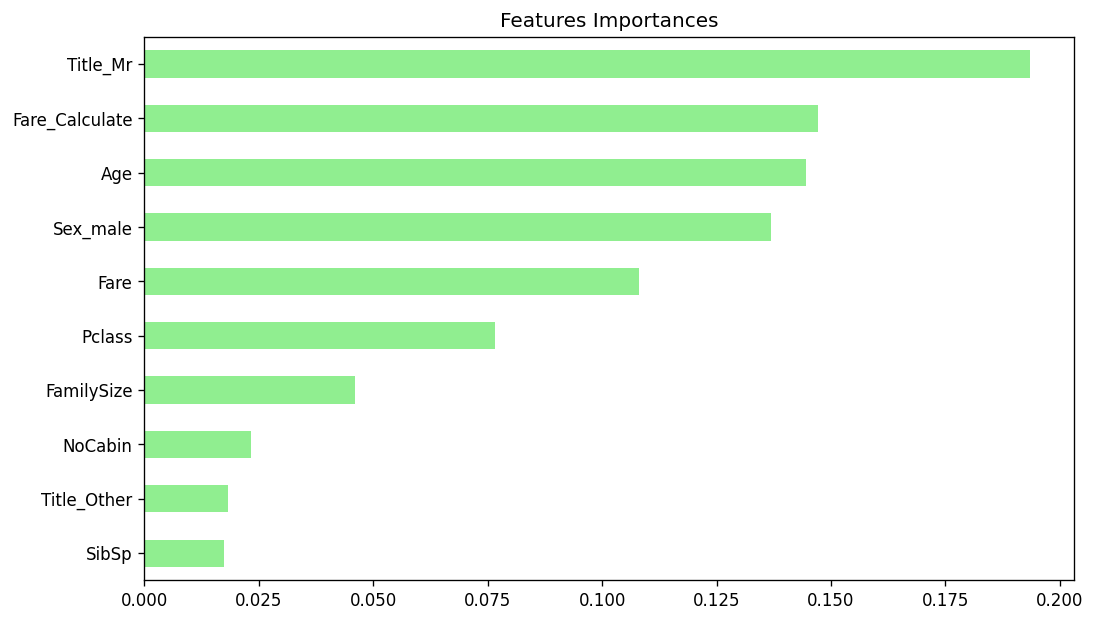

In [190]:
best = models[searchModel(models, results.index[0])][1]
best.fit(X, y)
plot_importances(best, X.columns, 10)

Show the tree if XGBoost model is the best model

In [191]:
## Only applicatble for XGBoost model
if type(best).__name__.startswith('XGBClassifier'):
    import xgboost
    xgboost.plot_tree(best)
    plt.show()
else:
    print('Not XGBClassifier')

Not XGBClassifier


## Model Prediction and Result Submission
Preparing the prediction results using the best model based on test score.

In [193]:
submission.Survived = best.predict(X_test)
submission.to_csv(OUTPUT_FOLDER + 'submission.csv', index=False) 

## References

1. https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
2. https://www.kaggle.com/kpacocha/top-5-titanic-machine-learning-from-disaster
3. https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner
4. https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/

--------